In [374]:
## Project title: Predicting students Mathematics performance using machine learning models

######################################################################################
# 1. Load the necessary packages
######################################################################################

# Data processing
import pandas as pd
import numpy as np
import random as rn

# Standardize the data
from sklearn.preprocessing import StandardScaler

# Modeling 
import tensorflow as tf
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE   ## to help with extreme imbalances in outcome variables for classification models.
from sklearn.linear_model import LogisticRegression                        ## For Logistic regression
from sklearn.linear_model import LogisticRegressionCV                      ## For Logistic regression CV
from sklearn.ensemble import GradientBoostingClassifier                    ## for GB classification
from sklearn.tree import DecisionTreeClassifier                            ## for DT classification
from sklearn.ensemble import RandomForestClassifier                        ## for RF classification
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV            ## for regularization
from sklearn.linear_model import lasso_path                                ## for lasso coef path
from sklearn.svm import SVC                                                ## for support vector classification
from sklearn.preprocessing import label_binarize

# Hyperparameter tuning
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score

# Plot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay    ## For confusipn matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Model evaluation
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, auc, roc_auc_score ## for classification
from sklearn import metrics

In [65]:
######################################################################################
## 2. Data import and pre-processing
######################################################################################
dat = pd.read_csv('GP_school_data.csv')
print(dat.shape)  ## check the shape of the data
#print(dat.columns) 


## selecting the variables of interest
## I was analysing the data in R-Studio, so most of the dummy coding and recoding and other cleaning have been made.
dat_1 = dat.drop(['school','address','sex', 'Medu','Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime',
                 'freetime', 'goout', 'Dalc','romantic', 'famsize', 'mom_home', 'mom_health', 'mom_other', 'mom_services',
                  'mom_teacher', 'dad_home', 'dad_health','dad_other', 'dad_services','dad_teacher',  
                  'less_fifteen', 'fifteen_and_thirty','thirty_to_hour', 'more_than_hour', 'Walc', 'Dalc', 
                  'Pstatus', 'studytime'], axis=1)


## recoding the binary variables from yes/no to 1/0
## First confirming the values 
yes_no_columns = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet']
#for col in yes_no_columns:
#    print(dat_1[col].value_counts())
    
## Now, recoding   
def recode(col):
    return col.map({'yes': 1, 'no': 0})
dat_1[yes_no_columns] = dat_1[yes_no_columns].apply(recode)

print(dat_1[['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet']].describe())

## creating thre datasets for each outcome (i.e., the continuous, binary, and multi-categorical)
dat_continuous = dat_1.drop(['G3_binary', 'G3_ordinal'], axis =1)
dat_binary = dat_1.drop(['G3', 'G3_ordinal'], axis =1)
dat_ordinal = dat_1.drop(['G3', 'G3_binary'], axis =1)
print(dat_1.shape)
print(dat_continuous.shape)
print(dat_binary.shape)
print(dat_ordinal.shape)
print(dat_1.columns)

(349, 71)
        schoolsup      famsup        paid  activities     nursery      higher  \
count  349.000000  349.000000  349.000000  349.000000  349.000000  349.000000   
mean     0.146132    0.641834    0.461318    0.530086    0.808023    0.951289   
std      0.353745    0.480150    0.499217    0.499811    0.394421    0.215571   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    1.000000    1.000000   
50%      0.000000    1.000000    0.000000    1.000000    1.000000    1.000000   
75%      0.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

         internet  
count  349.000000  
mean     0.851003  
std      0.356597  
min      0.000000  
25%      1.000000  
50%      1.000000  
75%      1.000000  
max      1.000000  
(349, 39)
(349, 37)
(349, 37)
(349, 37)
Index(['age', 'failures', 'schoolsup', '

In [368]:
######################################################################################
# 4. Data split and standardization for the continuous outcome
######################################################################################
# seed for reproducibility
seed = 999

## The below is necessary for starting Numpy generated random numbers
## in a well-defined initial state.
np.random.seed(seed)

# Train (80%) and test (20%) set split (For the contregress)
# Make separate data set for Y and X
Y_bin = dat_binary['G3_binary']
X_bin = dat_binary.drop(['G3_binary'], axis=1)

print(f'The dependent (Y) dataset has {Y_bin.shape}.')
print(f'The independent (X) dataset has {X_bin.shape}.')

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test  = train_test_split( X_bin, Y_bin, test_size = 0.2, random_state = 42)

print(f'The training dataset has {len(X_train)} observations')
print(f'The test dataset has {len(X_test)} observations')

# Standardization of continuous variable.
# VERY IMPORTANT: to avoid any information leaking from testing data to training data, we do standardization separately. 
# define continuous variable columns
continuous_vars = ['age', 'famrel', 'health', 'G1', 'G2', 'famrel']
scaler = StandardScaler()
X_train[continuous_vars] = scaler.fit_transform(X_train[continuous_vars])
X_test[continuous_vars] = scaler.fit_transform(X_test[continuous_vars])
print(X_train[continuous_vars].describe())
print(X_test[continuous_vars].describe())

## checking the dimension of data
print(f'The training dataset has {X_train.shape}')
print(f'The test dataset has {X_test.shape}')

The dependent (Y) dataset has (349,).
The independent (X) dataset has (349, 36).
The training dataset has 279 observations
The test dataset has 70 observations
                age        famrel        health            G1            G2  \
count  2.790000e+02  2.790000e+02  2.790000e+02  2.790000e+02  2.790000e+02   
mean   1.655386e-16  1.368877e-16 -6.048527e-17  3.501779e-17 -2.355742e-16   
std    1.001797e+00  1.001797e+00  1.001797e+00  1.001797e+00  1.001797e+00   
min   -1.291384e+00 -3.502358e+00 -1.891300e+00 -2.314836e+00 -2.701073e+00   
25%   -4.725290e-01  5.525565e-02 -4.336407e-01 -8.450152e-01 -4.273907e-01   
50%   -4.725290e-01  5.525565e-02  2.951891e-01  3.687722e-02  7.787204e-02   
75%    3.463256e-01  6.481913e-01  1.024019e+00  6.248055e-01  5.831348e-01   
max    4.440599e+00  1.241127e+00  1.024019e+00  2.388590e+00  2.098923e+00   

             famrel  
count  2.790000e+02  
mean   1.368877e-16  
std    1.001797e+00  
min   -3.502358e+00  
25%    5.525565e-0

Before OverSampling, counts of label '1 (Yes)': 184
Before OverSampling, counts of label '0 (No)': 95 

After OverSampling, the shape of train_X: (368, 36)
After OverSampling, the shape of train_y: (368,) 

After OverSampling, counts of label '1': 184
After OverSampling, counts of label '0': 184
The best parameters are {'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'splitter': 'best'}
Sensitivity: 0.90
Specificity: 0.94
Accuracy: 0.91
Area under the curve: 0.97


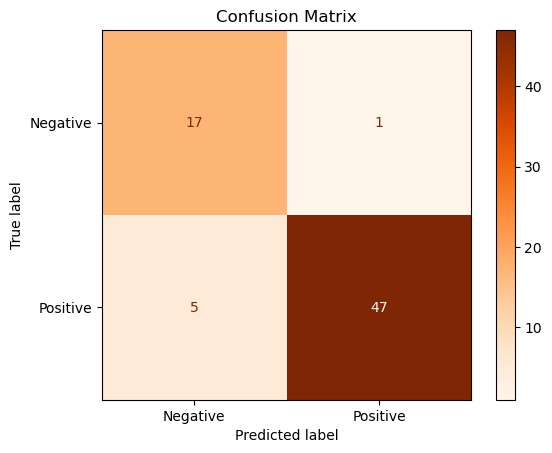

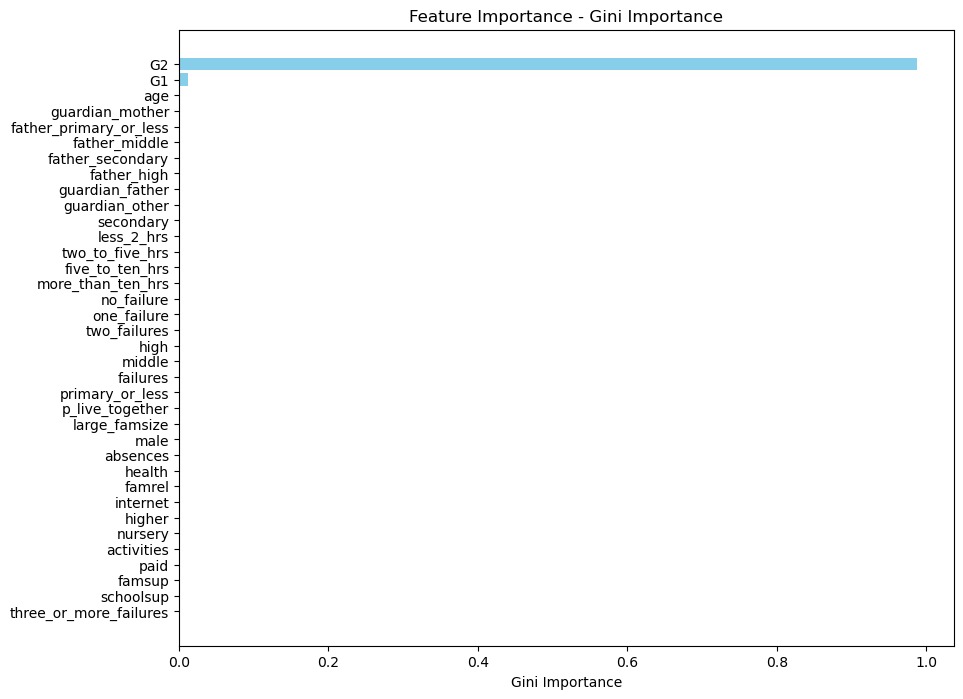

In [234]:
######################################################################################
# Decision tree classifier
######################################################################################
# creating new datasets for this analysis
x_test_dt = X_test
y_test_dt = y_test

# The DT classifier
dt = DecisionTreeClassifier()

# Hyperparameter search for GB.
dt_param_grid = {
    'criterion':  ['gini', 'entropy'],
    'max_depth':  [None, 2, 4, 6, 8, 10, 20, 30, 50, 100],
    'max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
    'splitter': ['best', 'random']
    }

# Instantiate the grid search model
# change verbose to any interger if you want to print out the message
dt_grid_search = GridSearchCV(estimator=dt, param_grid=dt_param_grid, n_jobs = -1, cv = 10, verbose=False)

# SMOTE in training data (Ensures a hypothetical balance between the binary variable)
sm = SMOTE(random_state=2)
x_train_dt, y_train_dt = sm.fit_resample(X_train, y_train)

# Print before SMOTE
print("Before OverSampling, counts of label '1 (Yes)': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0 (No)': {} \n".format(sum(y_train == 0)))
  
# Print after SMOTE
print('After OverSampling, the shape of train_X: {}'.format(x_train_dt.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_dt.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_dt == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_dt == 0)))

# Fit the model using training data after SMOTE
dt_grid_search.fit(x_train_dt, y_train_dt)

dt_best_grid = dt_grid_search.best_estimator_
dt_best_params = dt_grid_search.best_params_


######################################################################################
# Model evaluation and plotting
######################################################################################

# Calculate the area under the ROC curve (AUC)
roc_auc_dt = auc(fpr, tpr)

# print the best hyperparameters
print(f'The best parameters are {dt_best_params}')

## predicted classes (binary. 0 and 1)
y_hat_dt = dt_best_grid.predict(x_test_dt)  

# Calculate the confusion matrix
cm_dt = confusion_matrix(y_test_dt, y_hat_dt)

# Extract the true positives, true negatives, false positives, and false negatives
tn, fp, fn, tp = cm_dt.ravel()

# Calculate sensitivity (true positive rate)
sensitivity_dt = tp / (tp + fn)

# Calculate specificity (true negative rate)
specificity_dt = tn / (tn + fp)

# Calculate accuracy
accuracy_dt = (tp + tn) / (tp + tn + fp + fn)

# Print the sensitivity, specificity, and accuracy and auc
print(f"Sensitivity: {sensitivity_dt:.2f}") #
print(f"Specificity: {specificity_dt:.2f}") #
print(f"Accuracy: {accuracy_dt:.2f}") #
print(f"Area under the curve: {roc_auc_dt:.2f}")

## Confusion matrix
conf_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=["Negative", "Positive"])
conf_dt.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()


# Let's get variable importance
## Getting feature names from training data
feature_names_dt = x_test_dt.columns  

## Get feature importances
importances_dt = dt_best_grid.feature_importances_

## Create a DataFrame for display
feature_imp_dt = pd.DataFrame({
    'Feature': feature_names_dt,
    'Gini Importance': importances_dt
}).sort_values('Gini Importance', ascending=False)
#print(feature_imp_dt)

## Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_imp_dt['Feature'], feature_imp_dt['Gini Importance'], color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()
plt.show()


In [160]:
######################################################################################
# 4. Random forest
######################################################################################
# creating new datasets for this analysis
x_test_rf = X_test
y_test_rf = y_test

rf = RandomForestClassifier()

# Hyperparameter search (tunning) for RF.
rf_param_grid = {
    'max_depth': [20, 30],
    'max_features': [2, 3, 4, 5, 8,10], 
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [3, 4, 5],
    'n_estimators': [100, 200, 300]  
    }    

# Instantiate the grid search model
rf_grid_search = GridSearchCV (estimator = rf, param_grid = rf_param_grid, cv = 5, n_jobs = -1, verbose = False)


# Synthetic Minority Oversampling Technique (SMOTE) in training data
sm = SMOTE(random_state = 2)
x_train_rf, y_train_rf = sm.fit_resample(X_train, y_train)


# Print before SMOTE
print("Before OverSampling, counts of label '1 (Yes)': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0 (No)': {} \n".format(sum(y_train == 0)))
  
# Print after SMOTE
print('After OverSampling, the shape of train_X: {}'.format(x_train_rf.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_rf.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_rf == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_rf == 0)))


# Fit the model using training data after SMOTE
rf_grid_search.fit(x_train_rf, y_train_rf)


# Get the best model and its corresponding hyperparameters
rf_best_grid = rf_grid_search.best_estimator_
rf_best_params = rf_grid_search.best_params_


######################################################################################
# Model evaluation
######################################################################################

yscore_rf = rf_best_grid.predict_proba(x_test_rf)
yscorerf = [s[1] for s in yscore_rf]
fpr, tpr, thresh = roc_curve(y_test_rf, yscorerf)
#auc = roc_auc_score(y_test, yscore)

# Calculate the area under the ROC curve (AUC)
roc_auc_rf = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Plot the random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('Random_Forest.png')

# print the best hyperparameters
print(f'The best parameters are {rf_best_params}')

#The best parameters are {'max_depth': 20, 'max_features': 8, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 300}

y_hat_rf = rf_best_grid.predict(x_test_rf)

# Calculate the confusion matrix
cm_rf = confusion_matrix(y_test_rf, y_hat_rf)

# Extract the true positives, true negatives, false positives, and false negatives
tn, fp, fn, tp = cm_rf.ravel()

# Calculate sensitivity (true positive rate)
sensitivity_rf = tp / (tp + fn)

# Calculate specificity (true negative rate)
specificity_rf = tn / (tn + fp)

# Calculate accuracy
accuracy_rf = (tp + tn) / (tp + tn + fp + fn)

# Print the sensitivity, specificity, and accuracy
print(f"Sensitivity: {sensitivity_rf:.2f}")
print(f"Specificity: {specificity_rf:.2f}")
print(f"Accuracy: {accuracy_rf:.2f}")


## Confusion matrix
conf_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Negative", "Positive"])
conf_rf.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()


## Let's get variable importance
## Getting feature names from training data
feature_names_rf = x_test_rf.columns  

## Get feature importances
importances_rf = rf_best_grid.feature_importances_

## Create a DataFrame for display
feature_imp_rf = pd.DataFrame({
    'Feature': feature_names_rf,
    'Gini Importance': importances_rf
}).sort_values('Gini Importance', ascending=False)
#print(feature_imp_df)

## Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_imp_rf['Feature'], feature_imp_rf['Gini Importance'], color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()
plt.show()


Before OverSampling, counts of label '1 (Yes)': 184
Before OverSampling, counts of label '0 (No)': 95 

After OverSampling, the shape of train_X: (368, 36)
After OverSampling, the shape of train_y: (368,) 

After OverSampling, counts of label '1': 184
After OverSampling, counts of label '0': 184


In [200]:
######################################################################################
#  Gradient Boosting Model building
######################################################################################
# creating new datasets for this analysis
x_test_gb = X_test
y_test_gb = y_test

## The Gradient boosting Model
gb = GradientBoostingClassifier()

# Hyperparameter search for GB.
gb_param_grid = {
    "n_estimators":[50, 100, 300],  
    "max_depth":[1, 3, 5, 10],     
    "learning_rate":[0.01,0.1, 0.5],  
    "subsample": [0.5,0.8, 1.0], 
    "min_samples_split": [2, 5, 10],  
    "max_features": ['log2', 'sqrt'],
    "min_impurity_decrease": [ 0.3, 0.1, 0.08]
    }

# Activate the grid search model
gb_grid_search = GridSearchCV(estimator=gb, param_grid=gb_param_grid, n_jobs = -1, cv = 5, verbose=False)

# SMOTE in training data
sm = SMOTE(sampling_strategy=1.0,random_state=2)
x_train_gb, y_train_gb = sm.fit_resample(X_train, y_train)

# Print before SMOTE
print("Before OverSampling, counts of label '1 (Yes)': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0 (No)': {} \n".format(sum(y_train == 0)))

# Print after SMOTE
print('After OverSampling, the shape of train_X: {}'.format(x_train_gb.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_gb.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_gb == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_gb == 0)))

# Fit the model using training data after SMOTE
gb_grid_search.fit(x_train_gb, y_train_gb)

gb_best_grid = gb_grid_search.best_estimator_
gb_best_params = gb_grid_search.best_params_


######################################################################################
# Model evaluation and plotting
######################################################################################

yscore_gb = gb_best_grid.predict_proba(X_test)
yscoregb = [s[1] for s in yscore_gb]
fpr, tpr, thresh = roc_curve(y_test_gb, yscoregb)
#auc = roc_auc_score(y_test, yscore)

# Calculate the area under the ROC curve (AUC)
roc_auc_gb = auc(fpr, tpr)

#create ROC curve
plt.plot(fpr, tpr, label='%s ROC (area = %0.3f)' % ('Gradient Boosting', roc_auc_gb))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic-Gradient Boosting')
plt.legend(loc="lower right")
plt.savefig('Gradient Boosting.png')

# print the best hyperparameters
print(f'The best parameters are {gb_best_params}')

y_hat_gb = gb_best_grid.predict(x_test_gb)

# Calculate the confusion matrix
cm_gb = confusion_matrix(y_test_gb, y_hat_gb)

# Extract the true positives, true negatives, false positives, and false negatives
tn, fp, fn, tp = cm_gb.ravel()

# Calculate sensitivity (true positive rate)
sensitivity_gb = tp / (tp + fn)

# Calculate specificity (true negative rate)
specificity_gb = tn / (tn + fp)

# Calculate accuracy
accuracy_gb = (tp + tn) / (tp + tn + fp + fn)

# Print the sensitivity, specificity, and accuracy
print(f"Sensitivity: {sensitivity_gb:.2f}") #
print(f"Specificity: {specificity_gb:.2f}") #
print(f"Accuracy: {accuracy_gb:.2f}") #

## Confusion matrix
conf_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=["Negative", "Positive"])
conf_gb.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()


## Let's get variable importance
## Getting feature names from training data
feature_names_gb = x_test_gb.columns  

## Get feature importances
importances_gb = gb_best_grid.feature_importances_

## Create a DataFrame for display
feature_imp_gb = pd.DataFrame({
    'Feature': feature_names_gb,
    'Gini Importance': importances_gb
}).sort_values('Gini Importance', ascending=False)
#print(feature_imp_gbr)

## Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_imp_gb['Feature'], feature_imp_gb['Gini Importance'], color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()
plt.show()



Before OverSampling, counts of label '1 (Yes)': 184
Before OverSampling, counts of label '0 (No)': 95 

After OverSampling, the shape of train_X: (368, 36)
After OverSampling, the shape of train_y: (368,) 

After OverSampling, counts of label '1': 184
After OverSampling, counts of label '0': 184


The best parameters are {'learning_rate': 0.1, 'max_depth': 10, 'max_features': 'sqrt', 'min_impurity_decrease': 0.08, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 1.0}
Sensitivity: 0.92
Specificity: 0.83
Accuracy: 0.90


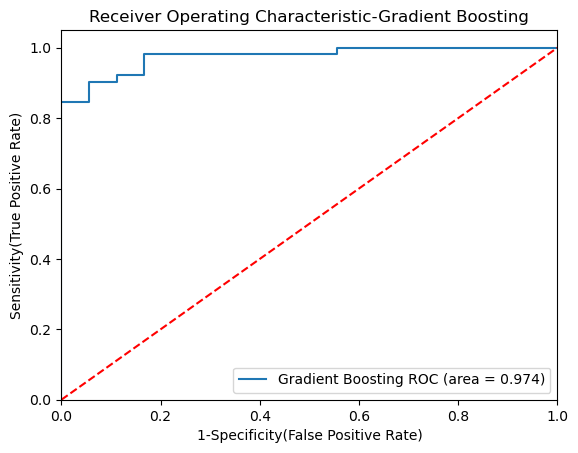

Before OverSampling, counts of label '1 (Yes)': 184
Before OverSampling, counts of label '0 (No)': 95 

After OverSampling, the shape of train_X: (368, 36)
After OverSampling, the shape of train_y: (368,) 

After OverSampling, counts of label '1': 184
After OverSampling, counts of label '0': 184
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy     : 0.9571
Sensitivity  : 0.9615
Specificity  : 0.9444

Confusion Matrix:
[[17  1]
 [ 2 50]]


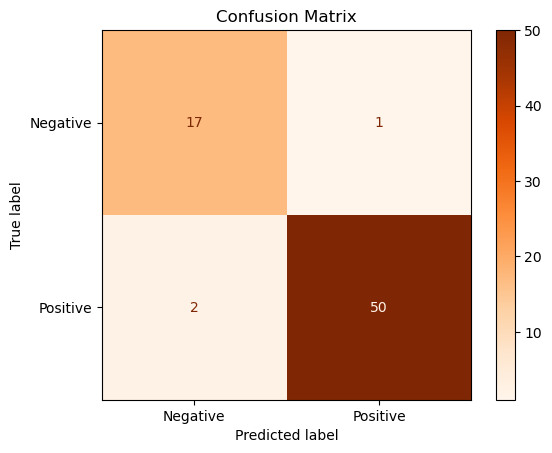

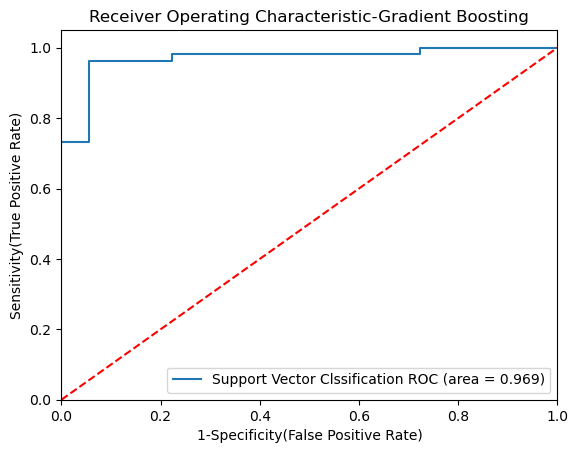

In [231]:
#############################################################
## Support Vector Machine (SVM)
#############################################################
# creating new datasets for this analysis
x_test_svc = X_test
y_test_svc = y_test

# SVC
svc = SVC(probability = True, random_state = 42)

# Parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf'],
    'gamma': ['scale', 0.01, 0.1, 1]
}

seed = 42
cv = KFold(n_splits=5, shuffle=True, random_state = seed)

# Grid search with reproducible splits
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# SMOTE in training data
sm = SMOTE(sampling_strategy=1.0,random_state=2)
x_train_svc, y_train_svc = sm.fit_resample(X_train, y_train)

# Print before SMOTE
print("Before OverSampling, counts of label '1 (Yes)': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0 (No)': {} \n".format(sum(y_train == 0)))

# Print after SMOTE
print('After OverSampling, the shape of train_X: {}'.format(x_train_svc.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_svc.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_svc == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_svc == 0)))


# The training model
svc_cv = grid_search.fit(x_train_svc, y_train_svc)

###########################################################################
#Test Set Evaluation
###########################################################################
best_svc = svc_cv.best_estimator_
y_pred_svc = best_svc.predict(x_test_svc)
y_prob_svc = best_svc.predict_proba(x_test_svc)[:, 1]


###########################################################################
# 7. Evaluation metrics
###########################################################################
cm_svc = confusion_matrix(y_test_svc, y_pred_svc)
tn, fp, fn, tp = cm_svc.ravel()
accuracy_svc = (tp + tn) / (tp + tn + fp + fn)
sensitivity_svc = tp / (tp + fn)
specificity_svc = tn / (tn + fp)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy     : {accuracy_svc:.4f}")
print(f"Sensitivity  : {sensitivity_svc:.4f}")
print(f"Specificity  : {specificity_svc:.4f}")
print("\nConfusion Matrix:")
print(cm_svc)

#  Confusion Matrix Plot
## Confusion matrix
conf_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=["Negative", "Positive"])
conf_svc.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_svc, y_prob_svc)
roc_auc_svc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='%s ROC (area = %0.3f)' % ('Support Vector Clssification', roc_auc_svc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic-Support Vector Classification')
plt.legend(loc="lower right")
plt.savefig('Support Vector Machine.png')


Before OverSampling, counts of label '1 (Yes)': 184
Before OverSampling, counts of label '0 (No)': 95 

After OverSampling, the shape of train_X: (368, 36)
After OverSampling, the shape of train_y: (368,) 

After OverSampling, counts of label '1': 184
After OverSampling, counts of label '0': 184
Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy     : 0.9143
Sensitivity  : 0.9038
Specificity  : 0.9444
[[17  1]
 [ 5 47]]
Classification Report:
               precision    recall  f1-score   support

           0      0.773     0.944     0.850        18
           1      0.979     0.904     0.940        52

    accuracy                          0.914        70
   macro avg      0.876     0.924     0.895        70
weighted avg      0.926     0.914     0.917        70



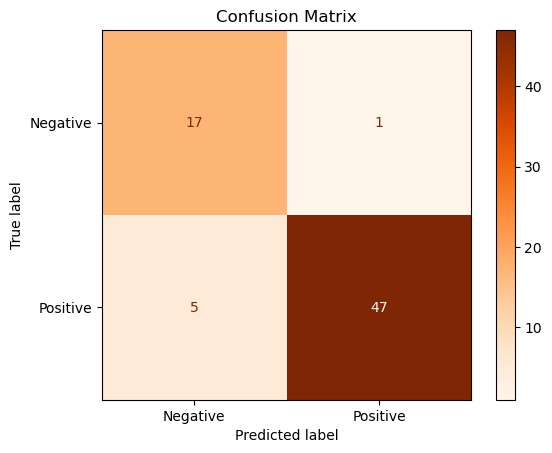

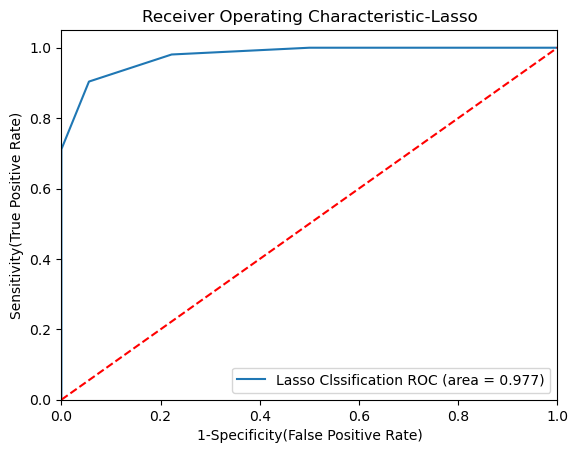

In [264]:
###########################################################################
#Lasso regression
###########################################################################
# creating new datasets for this analysis
x_test_lasso = X_test
y_test_lasso  = y_test

# Fit Lasso Logistic Regression
lasso_mod = LogisticRegressionCV(
    cv=5,
    penalty='l1',  ## 'l1' fpr Lasso penalty
    solver='saga',   # there are other options
    max_iter=10000,
    random_state=42
)

# SMOTE in training data
sm = SMOTE(sampling_strategy=1.0,random_state=2)
x_train_lasso, y_train_lasso = sm.fit_resample(X_train, y_train)

# Print before SMOTE
print("Before OverSampling, counts of label '1 (Yes)': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0 (No)': {} \n".format(sum(y_train == 0)))

# Print after SMOTE
print('After OverSampling, the shape of train_X: {}'.format(x_train_lasso.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_lasso.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_lasso == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_lasso == 0)))

# The training model
lasso_mod.fit(x_train_lasso , y_train_lasso)


# Prediction
y_pred_lasso  = lasso_mod.predict(x_test_lasso )               ## predicted class
y_proba_lasso  = lasso_mod.predict_proba(x_test_lasso )[:, 1]  ## Predicted probabilities  


# Evaluation
cm_lasso= confusion_matrix(y_test_lasso, y_pred_lasso)
tn, fp, fn, tp = cm_lasso.ravel()
accuracy_lasso= (tp + tn) / (tp + tn + fp + fn)
sensitivity_lasso = tp / (tp + fn)
specificity_lasso = tn / (tn + fp)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy     : {accuracy_lasso:.4f}")
print(f"Sensitivity  : {sensitivity_lasso:.4f}")
print(f"Specificity  : {specificity_lasso:.4f}")
print(cm_lasso)
print("Classification Report:\n", classification_report(y_test_lasso , y_pred_lasso , digits=3))


#  Confusion Matrix Plot
## Confusion matrix
conf_lasso = ConfusionMatrixDisplay(confusion_matrix=cm_lasso, display_labels=["Negative", "Positive"])
conf_lasso.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_lasso, y_proba_lasso)
roc_auc_lasso = auc(fpr, tpr)

plt.plot(fpr, tpr, label='%s ROC (area = %0.3f)' % ('Lasso Clssification', roc_auc_lasso))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic-Lasso')
plt.legend(loc="lower right")
plt.savefig('Lasso with binary outcome.png')



Before OverSampling, counts of label '1 (Yes)': 184
Before OverSampling, counts of label '0 (No)': 95 

After OverSampling, the shape of train_X: (368, 36)
After OverSampling, the shape of train_y: (368,) 

After OverSampling, counts of label '1': 184
After OverSampling, counts of label '0': 184
Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy     : 0.9429
Sensitivity  : 0.9615
Specificity  : 0.8889
[[16  2]
 [ 2 50]]
Classification Report:
               precision    recall  f1-score   support

           0      0.889     0.889     0.889        18
           1      0.962     0.962     0.962        52

    accuracy                          0.943        70
   macro avg      0.925     0.925     0.925        70
weighted avg      0.943     0.943     0.943        70



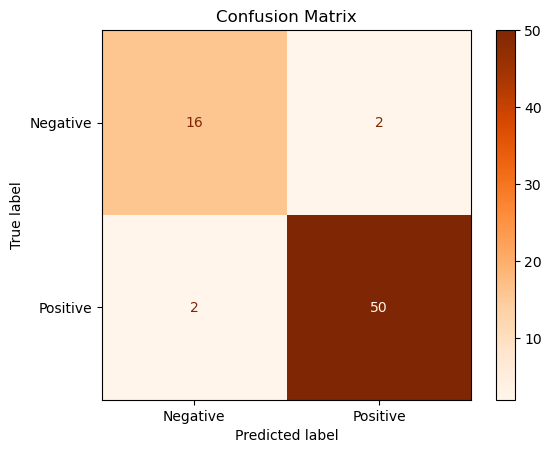

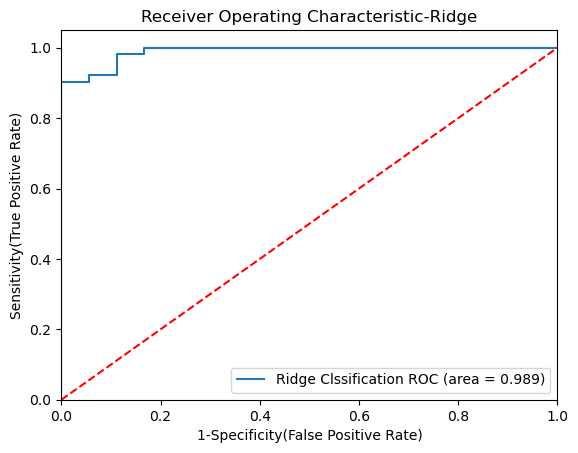

In [274]:
###########################################################################
#Ridge regression
###########################################################################
# creating new datasets for this analysis
x_test_ridge = X_test
y_test_ridge  = y_test

# Fit Ridge Logistic Regression
ridge_mod = LogisticRegressionCV(
    cv=5,
    penalty='l2',  ## 'l2' for Ridge penalty
    solver='lbfgs',
    max_iter=10000,
    random_state=42
)

# SMOTE in training data
sm = SMOTE(sampling_strategy=1.0,random_state=2)
x_train_ridge, y_train_ridge = sm.fit_resample(X_train, y_train)

# Print before SMOTE
print("Before OverSampling, counts of label '1 (Yes)': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0 (No)': {} \n".format(sum(y_train == 0)))

# Print after SMOTE
print('After OverSampling, the shape of train_X: {}'.format(x_train_ridge.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_ridge.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_ridge == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_ridge == 0)))

# The training model
ridge_mod.fit(x_train_ridge , y_train_ridge)


# Prediction
y_pred_ridge  = ridge_mod.predict(x_test_ridge)               ## predicted class
y_proba_ridge  = ridge_mod.predict_proba(x_test_ridge)[:, 1]  ## Predicted probabilities  


# Evaluation
cm_ridge= confusion_matrix(y_test_ridge, y_pred_ridge)
tn, fp, fn, tp = cm_ridge.ravel()
accuracy_ridge = (tp + tn) / (tp + tn + fp + fn)
sensitivity_ridge = tp / (tp + fn)
specificity_ridge = tn / (tn + fp)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy     : {accuracy_ridge:.4f}")
print(f"Sensitivity  : {sensitivity_ridge:.4f}")
print(f"Specificity  : {specificity_ridge:.4f}")
print(cm_ridge)
print("Classification Report:\n", classification_report(y_test_ridge, y_pred_ridge , digits=3))


#  Confusion Matrix Plot
## Confusion matrix
conf_ridge= ConfusionMatrixDisplay(confusion_matrix=cm_ridge, display_labels=["Negative", "Positive"])
conf_ridge.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_ridge, y_proba_ridge)
roc_auc_ridge = auc(fpr, tpr)

plt.plot(fpr, tpr, label='%s ROC (area = %0.3f)' % ('Ridge Clssification', roc_auc_ridge))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic-Ridge')
plt.legend(loc="lower right")
plt.savefig('Ridge with binary outcome.png')


Before OverSampling, counts of label '1 (Yes)': 184
Before OverSampling, counts of label '0 (No)': 95 

After OverSampling, the shape of train_X: (368, 36)
After OverSampling, the shape of train_y: (368,) 

After OverSampling, counts of label '1': 184
After OverSampling, counts of label '0': 184
Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy     : 0.9143
Sensitivity  : 0.9038
Specificity  : 0.9444
[[17  1]
 [ 5 47]]
Classification Report:
               precision    recall  f1-score   support

           0      0.773     0.944     0.850        18
           1      0.979     0.904     0.940        52

    accuracy                          0.914        70
   macro avg      0.876     0.924     0.895        70
weighted avg      0.926     0.914     0.917        70



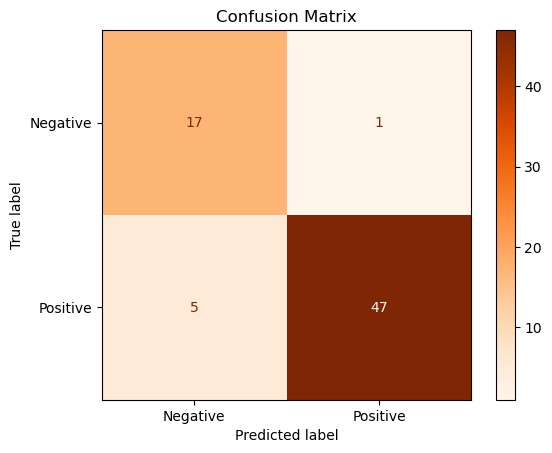

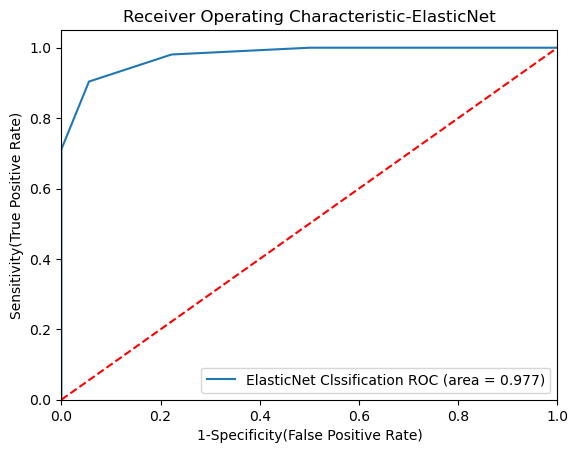

In [282]:
###########################################################################
# Elastic Net regression
###########################################################################
# creating new datasets for this analysis
x_test_enet = X_test
y_test_enet  = y_test

# Fit ENET Logistic Regression
enet_mod = LogisticRegressionCV(
    cv=5,
    penalty='elasticnet',  ## Elastic net
    solver='saga', 
    l1_ratios=[.07, .1, .5, .7, .9],  ## list of Elastic-Net mixing parameters
    max_iter=10000,
    random_state=22
)

# SMOTE in training data
sm = SMOTE(sampling_strategy=1.0,random_state=2)
x_train_enet, y_train_enet = sm.fit_resample(X_train, y_train)

# Print before SMOTE
print("Before OverSampling, counts of label '1 (Yes)': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0 (No)': {} \n".format(sum(y_train == 0)))

# Print after SMOTE
print('After OverSampling, the shape of train_X: {}'.format(x_train_enet.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_enet.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_enet == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_enet == 0)))

# The training model
enet_mod.fit(x_train_enet , y_train_enet)


# Prediction
y_pred_enet = enet_mod.predict(x_test_enet)               ## predicted class
y_proba_enet = enet_mod.predict_proba(x_test_enet)[:, 1]  ## Predicted probabilities  


# Evaluation
cm_enet= confusion_matrix(y_test_enet, y_pred_enet)
tn, fp, fn, tp = cm_enet.ravel()
accuracy_enet = (tp + tn) / (tp + tn + fp + fn)
sensitivity_enet = tp / (tp + fn)
specificity_enet = tn / (tn + fp)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy     : {accuracy_enet:.4f}")
print(f"Sensitivity  : {sensitivity_enet:.4f}")
print(f"Specificity  : {specificity_enet:.4f}")
print(cm_enet)
print("Classification Report:\n", classification_report(y_test_enet, y_pred_enet, digits=3))


#  Confusion Matrix Plot
## Confusion matrix
conf_enet= ConfusionMatrixDisplay(confusion_matrix=cm_enet, display_labels=["Negative", "Positive"])
conf_enet.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_enet, y_proba_enet)
roc_auc_enet = auc(fpr, tpr)

plt.plot(fpr, tpr, label='%s ROC (area = %0.3f)' % ('ElasticNet Clssification', roc_auc_enet))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic-ElasticNet')
plt.legend(loc="lower right")
plt.savefig('Elastic with binary outcome.png')

Before OverSampling, counts of label '1 (Yes)': 184
Before OverSampling, counts of label '0 (No)': 95 

After OverSampling, the shape of train_X: (368, 36)
After OverSampling, the shape of train_y: (368,) 

After OverSampling, counts of label '1': 184
After OverSampling, counts of label '0': 184


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy     : 0.9286
Sensitivity  : 0.9423
Specificity  : 0.8889
[[16  2]
 [ 3 49]]
Classification Report:
               precision    recall  f1-score   support

           0      0.842     0.889     0.865        18
           1      0.961     0.942     0.951        52

    accuracy                          0.929        70
   macro avg      0.901     0.916     0.908        70
weighted avg      0.930     0.929     0.929        70



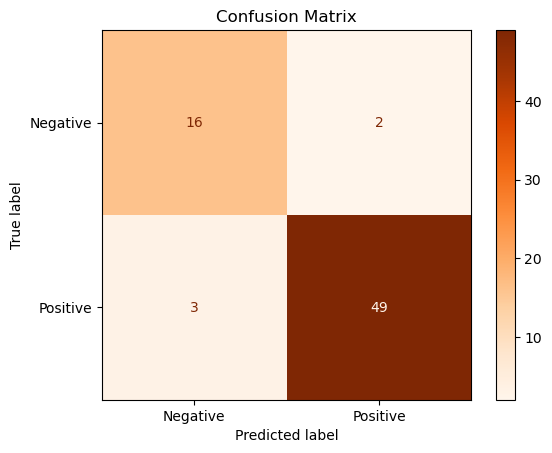

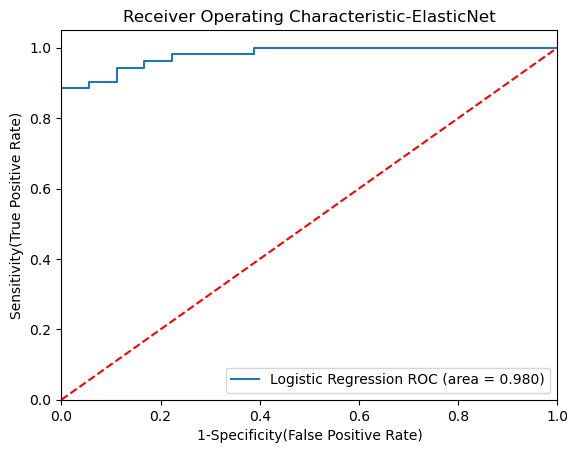

In [300]:
###########################################################################
# Logistic regression
###########################################################################
# creating new datasets for this analysis
x_test_logreg = X_test
y_test_logreg  = y_test

# Fit Logistic Regression
logreg_mod = LogisticRegression(
    penalty= 'none',  
    solver='lbfgs', 
    max_iter=10000,
    random_state=22
)

# SMOTE in training data
sm = SMOTE(sampling_strategy=1.0,random_state=2)
x_train_logreg, y_train_logreg= sm.fit_resample(X_train, y_train)

# Print before SMOTE
print("Before OverSampling, counts of label '1 (Yes)': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0 (No)': {} \n".format(sum(y_train == 0)))

# Print after SMOTE
print('After OverSampling, the shape of train_X: {}'.format(x_train_logreg.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_logreg.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_logreg == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_logreg == 0)))

# The training model
logreg_mod.fit(x_train_logreg, y_train_logreg)


# Prediction
y_pred_logreg = logreg_mod.predict(x_test_logreg)       ## predicted class
y_prob_logreg = logreg_mod.predict_proba(x_test_logreg)[:, 1]  ## Predicted probabilities 

# Evaluation
cm_logreg= confusion_matrix(y_test_logreg, y_pred_logreg)
tn, fp, fn, tp = cm_logreg.ravel()
accuracy_logreg= (tp + tn) / (tp + tn + fp + fn)
sensitivity_logreg = tp / (tp + fn)
specificity_logreg = tn / (tn + fp)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy     : {accuracy_logreg:.4f}")
print(f"Sensitivity  : {sensitivity_logreg:.4f}")
print(f"Specificity  : {specificity_logreg:.4f}")
print(cm_logreg)
print("Classification Report:\n", classification_report(y_test_logreg, y_pred_logreg, digits=3))


#  Confusion Matrix Plot
## Confusion matrix
conf_logreg= ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=["Negative", "Positive"])
conf_logreg.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_logreg, y_prob_logreg)
roc_auc_logreg = auc(fpr, tpr)

plt.plot(fpr, tpr, label='%s ROC (area = %0.3f)' % ('Logistic Regression', roc_auc_logreg))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic-ElasticNet')
plt.legend(loc="lower right")
plt.savefig('Logistic Regression.png')

                  Model       Metric     Score
0   Logistic Regression  Sensitivity  0.942308
1                 Lasso  Sensitivity  0.903846
2                 Ridge  Sensitivity  0.961538
3            ElasticNet  Sensitivity  0.903846
4         Decision Tree  Sensitivity  0.903846
5         Random Forest  Sensitivity  0.903846
6     Gradient Boosting  Sensitivity  0.923077
7                   SVC  Sensitivity  0.961538
8   Logistic Regression  Specificity  0.888889
9                 Lasso  Specificity  0.944444
10                Ridge  Specificity  0.888889
11           ElasticNet  Specificity  0.944444
12        Decision Tree  Specificity  0.944444
13        Random Forest  Specificity  0.944444
14    Gradient Boosting  Specificity  0.833333
15                  SVC  Specificity  0.944444
16  Logistic Regression     Accuracy  0.928571
17                Lasso     Accuracy  0.914286
18                Ridge     Accuracy  0.942857
19           ElasticNet     Accuracy  0.914286
20        Dec

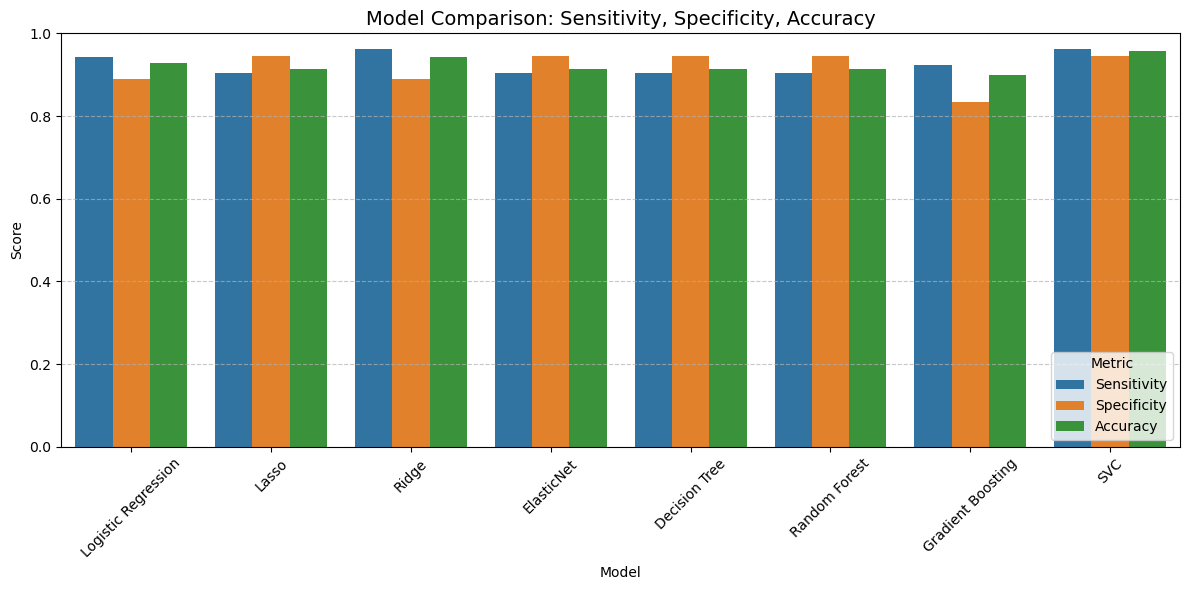

In [397]:
################################################################
## Plotting the R2_score for all the models and choose the best
################################################################
model_names = ['Logistic Regression', 'Lasso', 'Ridge', 'ElasticNet', 'Decision Tree',
               'Random Forest', 'Gradient Boosting', 'SVC']

sensitivity = [sensitivity_logreg,sensitivity_lasso, sensitivity_ridge, sensitivity_enet, sensitivity_dt, 
               sensitivity_rf, sensitivity_gb, sensitivity_svc]

specificity = [specificity_logreg, specificity_lasso, specificity_ridge, specificity_enet, specificity_dt, 
               specificity_rf, specificity_gb, specificity_svc]

accuracy = [accuracy_logreg, accuracy_lasso, accuracy_ridge, accuracy_enet, accuracy_dt, 
            accuracy_rf, accuracy_gb, accuracy_svc]


# Build long-form dataframe
metrics_df = pd.DataFrame({
    'Model': model_names * 3,
    'Metric': ['Sensitivity'] * len(model_names) +
              ['Specificity'] * len(model_names) +
              ['Accuracy'] * len(model_names),
    'Score': sensitivity + specificity + accuracy
})
print(metrics_df)

# Plot grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_df, x='Model', y='Score', hue='Metric')
plt.title('Model Comparison: Sensitivity, Specificity, Accuracy', fontsize=14)
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metric', loc='lower right')
plt.tight_layout()
plt.savefig('Model performance (binary target variable).png')
plt.show()
